# Using `cenpy` to analyze Segregation in US Cities

*Levi John Wolf*

University of Bristol

levi.john.wolf@bristol.ac.uk

`cenpy` makes it dead simple to fetch demographic data. It works by automatically *discovering* different data products made available by the US Census Bureau, *exposing* these data products in a consistent pythonic fashion, and then *wrangling* the data into a clean `geopandas` dataframe. This is useful in the analysis of segregation in American cities. It's often difficult to do large-scale demographic analysis because demographic data at sufficiently fine-grained spatial resolution is hard to get and process over a large geographic extent. A few cities in a few states rapidly becomes a difficult analytical task. With `cenpy`, though, this becomes easy. 

Further, the new `segregation` package allows for the computation and comparison of segregation measures in different urban systems. While it's often easy to compute a single measure of segregation, it's difficult to conduct *inference* on that measure. Thus, we can easily figure out *how* segregated a place is, but not figure out the intrinsic uncertainty in that estimated segregation measure. Further, *comparing* segregation indices between places or across time should consider this uncertainty. 

Fortunately, using `cenpy` and `segregation` packages in Python, we can conduct fast analyses to examine how segregation changes over time or between cities. Below, I'll walk through an example of how you can examine changes in the segregation of Hispanic populations over time in Phoenix and comparison of segregation between Phoenix and Austin. 

# Importing packages

First, the packages we need are `cenpy` and `segregation`. But, to help get a sense of what the areas look like, I use `contextily`, a simple package to request basemap tiles to use in matplotlib plots. 

In [1]:
import cenpy
import segregation
import contextily
%matplotlib inline

Cenpy has two different ways it can be used. The new `product` API focus on using geographical names to make querying [as simple as possible](https://nbviewer.jupyter.org/gist/ljwolf/3481aeadf1b0fbb46b72553a08bfc4e6?flush_cache=true). But, because it requires a little more prior knowledge about how queries should be formed, there are a limited number of data products that are supported. The 5-year ACS and 2010 Decennial census are supported. By default, the most recent 5-year ACS is fetched. 

In [2]:
acs = cenpy.products.ACS()

Once the product is built, it has a few useful attributes. All of the *variables*, or columns in the Census's database, are contained within the dataframe `variables`:

In [26]:
acs.variables

,attributes,concept,group,label,limit,predicateOnly,predicateType,required,values
AIANHH,NaN,NaN,N/A,Geography,0,NaN,NaN,NaN,NaN
AIHHTL,NaN,NaN,N/A,Geography,0,NaN,NaN,NaN,NaN
AIRES,NaN,NaN,N/A,Geography,0,NaN,NaN,NaN,NaN
ANRC,NaN,NaN,N/A,Geography,0,NaN,NaN,NaN,NaN
B00001_001E,B00001_001EA,UNWEIGHTED SAMPLE COUNT OF THE POPULATION,B00001,Estimate!!Total,0,NaN,int,NaN,NaN
B00002_001E,B00002_001EA,UNWEIGHTED SAMPLE HOUSING UNITS,B00002,Estimate!!Total,0,NaN,int,NaN,NaN
B01001A_001E,"B01001A_001M,B01001A_001MA,B01001A_001EA",SEX BY AGE (WHITE ALONE),B01001A,Estimate!!Total,0,NaN,int,NaN,NaN
B01001A_002E,"B01001A_002M,B01001A_002MA,B01001A_002EA",SEX BY AGE (WHITE ALONE),B01001A,Estimate!!Total!!Male,0,NaN,int,NaN,NaN
B01001A_003E,"B01001A_003M,B01001A_003MA,B01001A_003EA",SEX BY AGE (WHITE ALONE),B01001A,Estimate!!Total!!Male!!Under 5 years,0,NaN,int,NaN,NaN
B01001A_004E,"B01001A_004M,B01001A_004MA,B01001A_004EA",SEX BY AGE (WHITE ALONE),B01001A,Estimate!!Total!!Male!!5 to 9 years,0,NaN,int,NaN,NaN


That's a lot of variables! There are *so many variables* it's nearly impossible to understand them all at a glance. This is because most census tables are composed of a *table* identifier, which tells you the general topic of the variable, and then a *position* in that table. Fortunately, `cenpy` allows you to examine the `tables` directly, which are a little easier to understand:

In [27]:
acs.tables

,description,columns
table_name,,
B00001,UNWEIGHTED SAMPLE COUNT OF THE POPULATION,[B00001_001E]
B00002,UNWEIGHTED SAMPLE HOUSING UNITS,[B00002_001E]
B01001,SEX BY AGE,"[B01001_001E, B01001_002E, B01001_003E, B01001..."
B01002,MEDIAN AGE BY SEX,"[B01002_001E, B01002_002E, B01002_003E]"
B01003,TOTAL POPULATION,[B01003_001E]
B02001,RACE,"[B02001_001E, B02001_002E, B02001_003E, B02001..."
B02008,WHITE ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02008_001E]
B02009,BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...,[B02009_001E]
B02010,AMERICAN INDIAN AND ALASKA NATIVE ALONE OR IN ...,[B02010_001E]


Still, there are way too many tables to inspect individually. And, `tables` only provides the *main* tables, not the cross-tabulations by race, sex, or age which are exposed in `crosstab_tables`. This problem means we need an efficient way to *filter* the set of tables (or variables) to focus on a specific topic. The `filter_tables` and `filter_variables` make this simple. There, you can filter based on table names or based on text that's within the description of the table/variable. For instance, to focus in on all tables that mention "race" in the ACS, you can use:

In [28]:
acs.filter_tables('RACE', by='description')

,description,columns
table_name,,
B02001,RACE,"[B02001_001E, B02001_002E, B02001_003E, B02001..."
B02008,WHITE ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02008_001E]
B02009,BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...,[B02009_001E]
B02010,AMERICAN INDIAN AND ALASKA NATIVE ALONE OR IN ...,[B02010_001E]
B02011,ASIAN ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02011_001E]
B02012,NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALO...,[B02012_001E]
B02013,SOME OTHER RACE ALONE OR IN COMBINATION WITH O...,[B02013_001E]
B03002,HISPANIC OR LATINO ORIGIN BY RACE,"[B03002_001E, B03002_002E, B03002_003E, B03002..."
B25006,RACE OF HOUSEHOLDER,"[B25006_001E, B25006_002E, B25006_003E, B25006..."


To focus on tables that mention hispanic or not hispanic information:

In [29]:
acs.filter_tables('HISPANIC', by='description')

,description,columns
table_name,,
B03001,HISPANIC OR LATINO ORIGIN BY SPECIFIC ORIGIN,"[B03001_001E, B03001_002E, B03001_003E, B03001..."
B03002,HISPANIC OR LATINO ORIGIN BY RACE,"[B03002_001E, B03002_002E, B03002_003E, B03002..."
B03003,HISPANIC OR LATINO ORIGIN,"[B03003_001E, B03003_002E, B03003_003E]"
B16006,LANGUAGE SPOKEN AT HOME BY ABILITY TO SPEAK EN...,"[B16006_001E, B16006_002E, B16006_003E, B16006..."
B98013,TOTAL POPULATION COVERAGE RATE BY WEIGHTING RA...,"[B98013_001E, B98013_002E, B98013_003E, B98013..."
B99031,ALLOCATION OF HISPANIC OR LATINO ORIGIN,"[B99031_001E, B99031_002E, B99031_003E]"


Since we see that `B03002` looks like a good table to focus on, we can narrow down the variables we are interested in using `filter_variables`:

In [30]:
acs.filter_variables('B03002')

,attributes,concept,group,label,limit,predicateOnly,predicateType,required,values
B03002_021E,"B03002_021M,B03002_021MA,B03002_021EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Hispanic or Latino!!Two or mo...,0,NaN,int,NaN,NaN
B03002_020E,"B03002_020M,B03002_020MA,B03002_020EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Hispanic or Latino!!Two or mo...,0,NaN,int,NaN,NaN
B03002_001E,"B03002_001M,B03002_001MA,B03002_001EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total,0,NaN,int,NaN,NaN
B03002_005E,"B03002_005M,B03002_005MA,B03002_005EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!Ameri...,0,NaN,int,NaN,NaN
B03002_004E,"B03002_004M,B03002_004MA,B03002_004EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!Black...,0,NaN,int,NaN,NaN
B03002_003E,"B03002_003M,B03002_003MA,B03002_003EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!White...,0,NaN,int,NaN,NaN
B03002_002E,"B03002_002M,B03002_002MA,B03002_002EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino,0,NaN,int,NaN,NaN
B03002_009E,"B03002_009M,B03002_009MA,B03002_009EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!Two o...,0,NaN,int,NaN,NaN
B03002_007E,"B03002_007M,B03002_007MA,B03002_007EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!Nativ...,0,NaN,int,NaN,NaN
B03002_008E,"B03002_008M,B03002_008MA,B03002_008EA",HISPANIC OR LATINO ORIGIN BY RACE,B03002,Estimate!!Total!!Not Hispanic or Latino!!Some ...,0,NaN,int,NaN,NaN


There, we see that the relevant columns are those measuring the full population, the hispanic population, and the not hispanic population:

In [9]:
hispanic = ['B03002_001', # full population 
            'B03002_002', # nonhispanic
            'B03002_012' # hispanic 
           ]

Altogether, grabbing the data for a city can be done using the `from_place` method:

In [10]:
phoenix = acs.from_place('Phoenix, AZ', variables=hispanic)

/home/lw17329/Dropbox/dev/cenpy/cenpy/geoparser.py:214: UserWarning: Shape is invalid: 
Ring Self-intersection[-12486597.5213 3939710.1975]
  tell_user('Shape is invalid: \n{}'.format(vexplain))


Matched: Phoenix, AZ to Phoenix city within layer Incorporated Places


With this, we can use `contextily` to grab a basemap:

In [11]:
phoenix_basemap, phoenix_extent = contextily.bounds2img(*phoenix.total_bounds, zoom=10, 
                                                        url=contextily.tile_providers.ST_TONER_LITE)

And plot the percentage hispanic population:

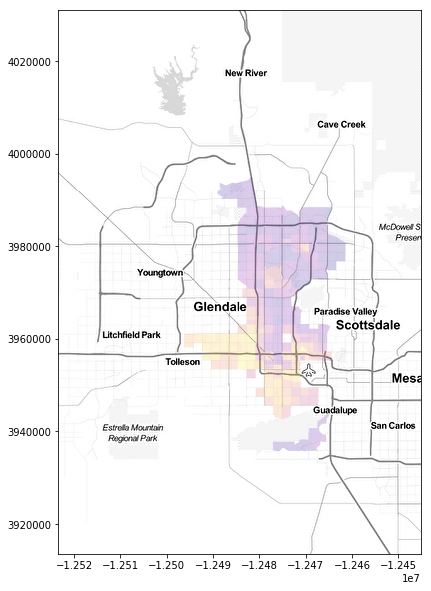

In [63]:
f,ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(phoenix_basemap, extent=phoenix_extent, interpolation='sinc')
phoenix['pct_hispanic'] = phoenix.eval('B03002_012E / B03002_001E')
phoenix.plot('pct_hispanic', cmap='plasma', ax = ax, alpha=.2)

# Estimating Segregation

To compute segregation in Phoenix for the 2017 five-year ACS, the `segregation` package takes the dataframe and column names containing the group under study and the total population. For this, you can estimate the Massey-Denton Dissimilarity statistic using the `segregation.aspatial.Dissim` estimator:

In [64]:
seg_phoenix = segregation.aspatial.Dissim(phoenix, 
                                          group_pop_var='B03002_012E', 
                                          total_pop_var='B03002_001E')

Thus, for 2017, the hispanic/not hispanic dissimilarity index for Phoenix, measured at the census tract level, is:

In [65]:
seg_phoenix.statistic

0.5004851624821972

While this computes the dissimilarity metric, it does *not* conduct inference on that value. `segregation` has a generic testing framework, `segregation.inference`, that can estimate and re-estimate segregation indices under certain assumptions. Below, we'll compute the segregation of random maps, assuming populations are randomly distributed across the map.

In [66]:
phx_test = segregation.inference.SingleValueTest(seg_phoenix)

Then, we can plot this to compare the segregation in our random Phoenix maps to the Phoenix we did observe in 2017:

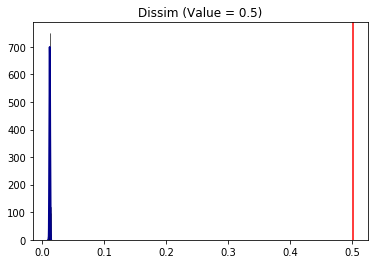

In [67]:
phx_test.plot()

Thus, Phoenix's hispanic/not hispanic dissimilarity value is *very* different from the values we would expect if populations were randomly distributed across the city. 

# Comparing across time

`cenpy` exposes ACSs back to 2013. Thus, we can get the earliest ACS data for Phoenix available from the API using:

In [69]:
phoenix_2013 = cenpy.products.ACS(2013).from_place('Phoenix, AZ', variables=hispanic)
phoenix_2013['pct_hispanic'] = phoenix_2013.eval('B03002_012E / B03002_001E')

/home/lw17329/Dropbox/dev/cenpy/cenpy/geoparser.py:214: UserWarning: Shape is invalid: 
Ring Self-intersection[-12486597.5213 3939710.1975]
  tell_user('Shape is invalid: \n{}'.format(vexplain))


Matched: Phoenix, AZ to Phoenix city within layer Incorporated Places


And, we can compare the spatial distributions visually:

Text(0.5, 1.0, 'Relative Change')

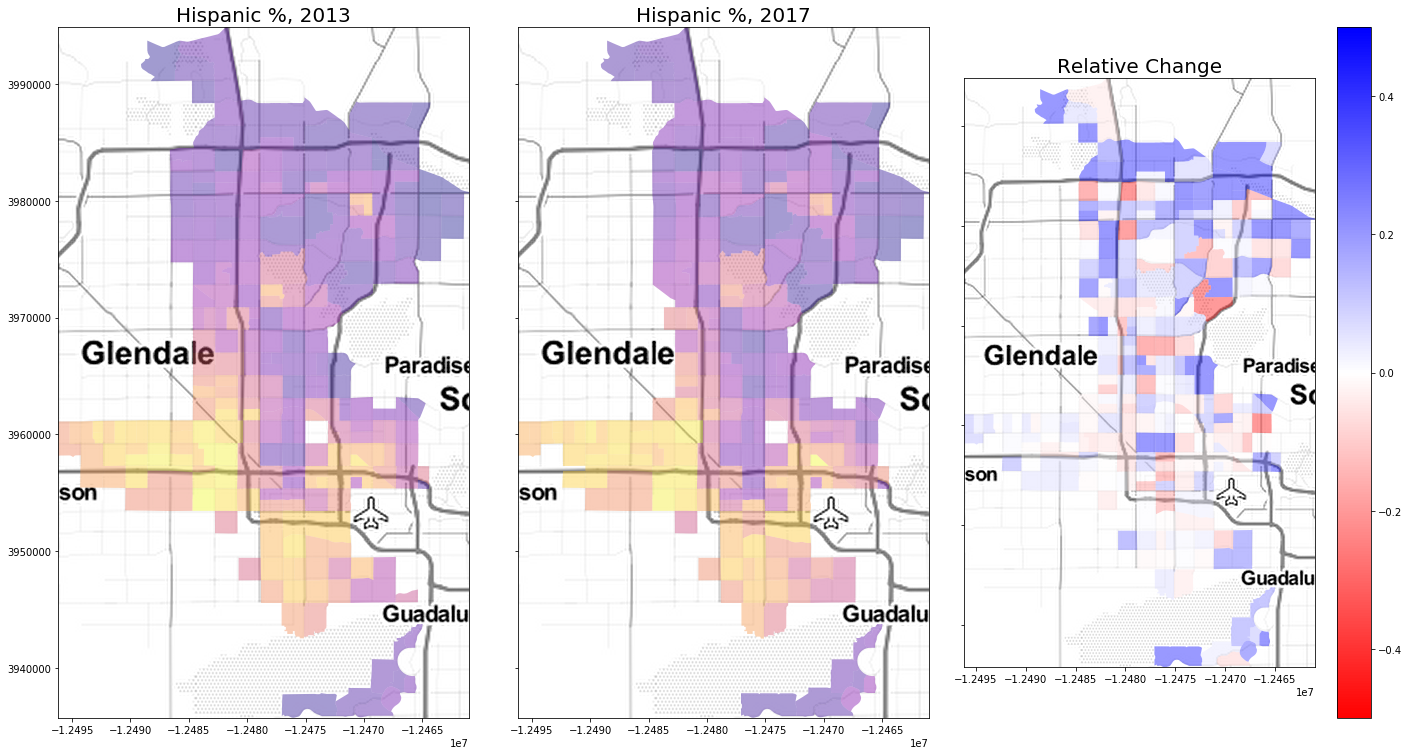

In [78]:
f,ax = plt.subplots(1,3, figsize=(20,10), sharex=True, sharey=True)
[ax_.imshow(phoenix_basemap, extent=phoenix_extent, interpolation='sinc') for ax_ in ax]
phoenix.plot('pct_hispanic', cmap='plasma', ax = ax[1], alpha=.4)
phoenix_2013.plot('pct_hispanic', cmap='plasma', ax = ax[0], alpha=.4)
phoenix.merge(phoenix_2013.drop('geometry',axis=1), on='GEOID', suffixes=('_2017', '_2013'))\
       .eval('pct_change = (pct_hispanic_2017 - pct_hispanic_2013)/(pct_hispanic_2013)')\
       .plot('pct_change', cmap='bwr_r', ax=ax[2], alpha=.4, vmin=-.5, vmax=.5, legend=True)
f.tight_layout()
ax[0].axis(phoenix.total_bounds[[0,2,1,3]])
ax[0].set_title('Hispanic %, 2013', fontsize=20)
ax[1].set_title('Hispanic %, 2017', fontsize=20)
ax[2].set_title('Relative Change', fontsize=20)

To compute the segregation index in 2013, we use the same strategy as before:

In [72]:
seg_phoenix_2013 = segregation.aspatial.Dissim(phoenix_2013, 
                                              group_pop_var='B03002_012E', 
                                              total_pop_var='B03002_001E')

In [76]:
seg_phoenix_2013.statistic

0.5234336505646645

Now, though, with *two* statistics (one in 2013 and one in 2017), we can compare the two probabilistically using the `segregation.inference.TwoValueTest`:

In [79]:
time_comparison = segregation.inference.TwoValueTest(seg_phoenix, seg_phoenix_2013)

Subjectively, we saw that the statistics were pretty similar. Objectively, the simulation-based inference confirms this intuition. Our estimated difference suggests that the dissimilarity index dropped slightly (from .52 in 2013 to .5 in 2017). But, this drop is within what we'd expect, given the uncertainty in estimating the two segregation indices. The red line is the estimated difference between the two segregation indices, and the blue histogram shows the distribution of simulated differences, which takes into account our uncertainty:

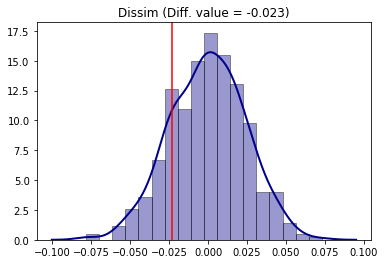

In [75]:
time_comparison.plot()

# Compared to another city?

Cenpy works on *any* place that's recognized in `census` places. If we wanted to compare segregation between different *cities*, we can do this also with `cenpy` & `segregation`. For instance, to get Austin, Texas's data from the ACS:

In [80]:
austin = acs.from_place('Austin, TX', variables=hispanic)

/home/lw17329/Dropbox/dev/cenpy/cenpy/geoparser.py:214: UserWarning: Shape is invalid: 
Ring Self-intersection[-10884881.1468 3554135.7868]
  tell_user('Shape is invalid: \n{}'.format(vexplain))


Matched: Austin, TX to Austin city within layer Incorporated Places


Just like before, we can get basemaps using `contextily` and make nice maps:

In [81]:
austin_basemap, austin_extent = contextily.bounds2img(*austin.total_bounds, zoom=12, url=contextily.tile_providers.ST_TONER_LITE)

Text(0.5, 1.0, 'Hispanic % (Phoenix)')

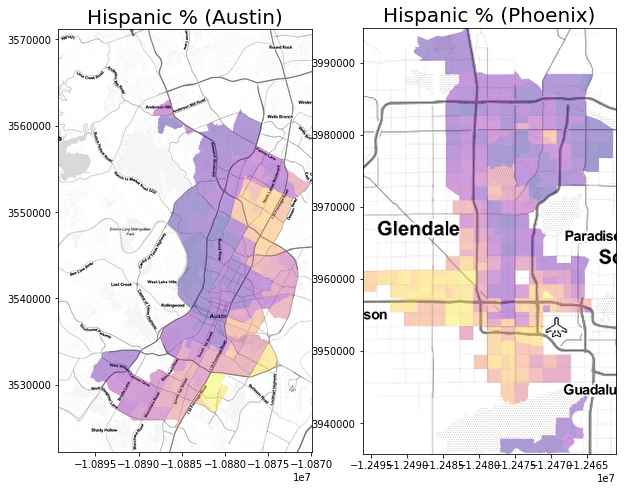

In [94]:
f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(austin_basemap, extent=austin_extent, interpolation='sinc')
ax[1].imshow(phoenix_basemap, extent=phoenix_extent, interpolation='sinc')
austin.eval('pct_hispanic = B03002_012E / B03002_001E').plot('pct_hispanic', cmap='plasma', ax = ax[0], alpha=.4)
phoenix.plot('pct_hispanic', cmap='plasma', ax=ax[1], alpha=.4)
ax[1].axis(phoenix.total_bounds[[0,2,1,3]])
ax[0].set_title('Hispanic % (Austin)', fontsize=20)
ax[1].set_title('Hispanic % (Phoenix)', fontsize=20)

Estimating the difference between segregation in the two cities is difficult. While we can simply compare the raw estimated Dissimilarity score: 

In [95]:
seg_austin = segregation.aspatial.Dissim(austin, group_pop_var='B03002_012E', total_pop_var='B03002_001E')

In [96]:
seg_austin.statistic, seg_phoenix.statistic

(0.421753840915938, 0.5004851624821972)

This doesn't take into account the intrinsic uncertainty in that Dissimilarity estimate. Further, it's hard to understand how to compare the two cities, given that they've got distinctive geographical structures. But, the `segregation` package takes care of this automatically:

In [98]:
test = segregation.inference.TwoValueTest(seg_austin, seg_phoenix)

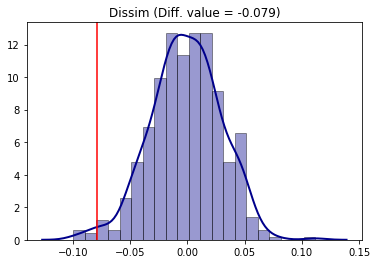

In [99]:
test.plot()

Thus, we see that Austin is significantly less segregated that Phoenix, even when acounting for the uncertainty around estimating the Dissimilarity metric. 